In [38]:
%pylab inline
import pandas as pd
import datetime as dt
import requests
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.stats import uniform, norm, multivariate_normal

pd.plotting.register_matplotlib_converters()

matplotlib.rcParams['figure.figsize'] = (10,6)
matplotlib.rcParams['axes.grid'] = True

Populating the interactive namespace from numpy and matplotlib


/Users/jonny/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['beta', 'gamma', 'f', 'norm', 'i0', 'uniform']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Data Collection

In [169]:
country = 'US'
data = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
US = data[(data["Country/Region"] == country)]
US = pd.DataFrame({"confirmed" : US.iloc[:, 4:].sum(), "date" : pd.to_datetime(US.columns[4:], format="%m/%d/%y")})

data = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
US_deaths = data[(data["Country/Region"] == country)]
US_deaths = pd.DataFrame({"deaths" : US_deaths.iloc[:, 4:].sum(), "date" : pd.to_datetime(US_deaths.columns[4:], format="%m/%d/%y")})

dataset = np.array([US['confirmed'].values, US_deaths['deaths']])

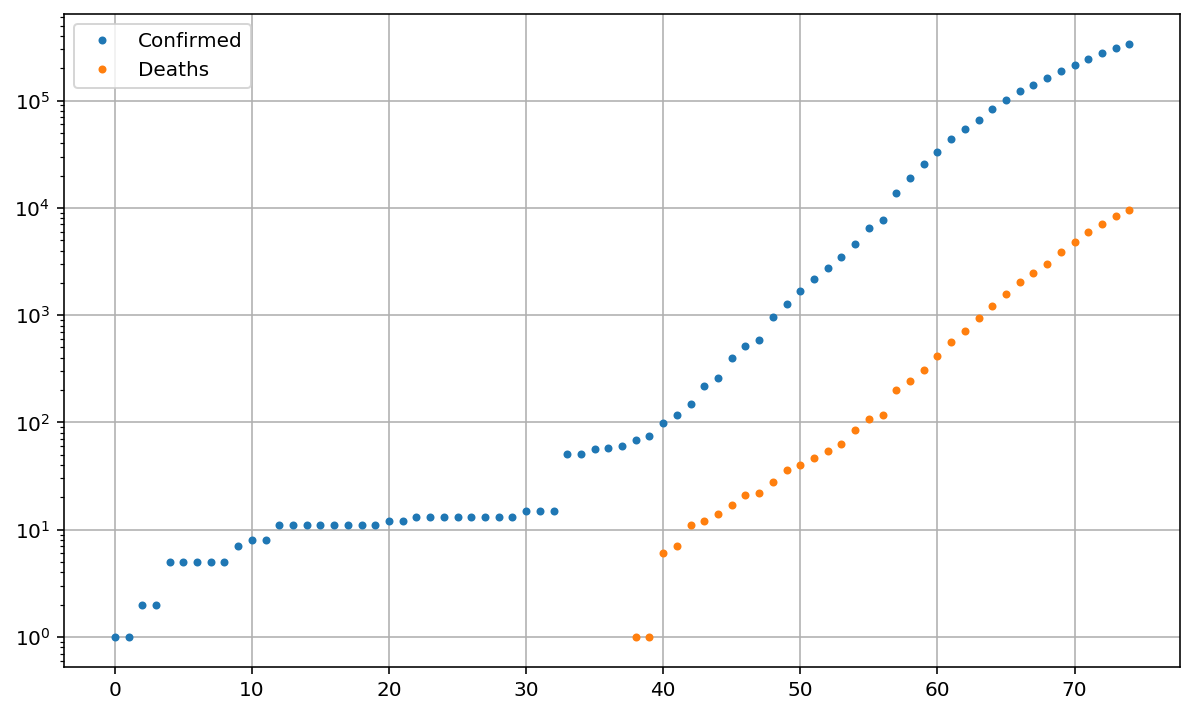

In [170]:
f = plt.figure()
plt.semilogy(dataset[0,:], '.', c='C0', label='Confirmed')
plt.semilogy(dataset[1,:], '.', c='C1', label='Deaths')
plt.legend()

## Augmented SIR model

$$\begin{align}
& \frac{dS}{dt} = - \frac{\beta I S}{N}, \\
& \frac{dI}{dt} = \frac{\beta I S}{N}- \gamma I, \\
& \frac{dR}{dt} = \gamma I, \\
& \frac{d\beta}{dt} = -k_\beta \beta,
\end{align}$$

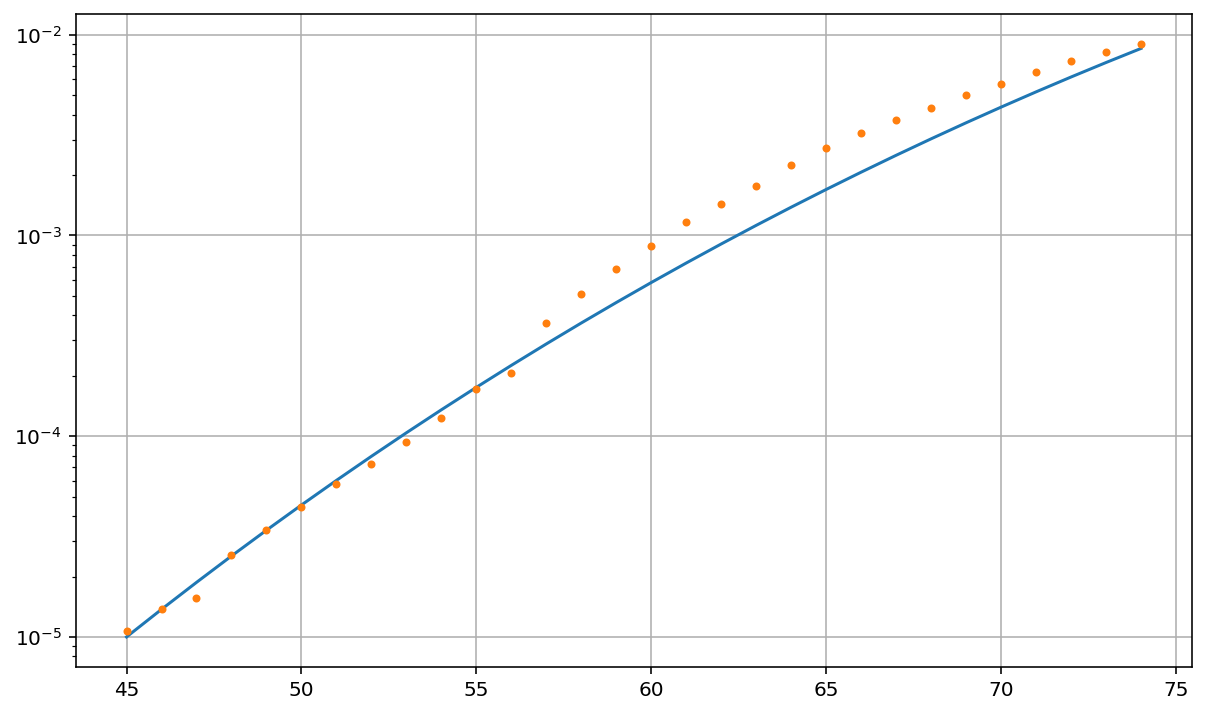

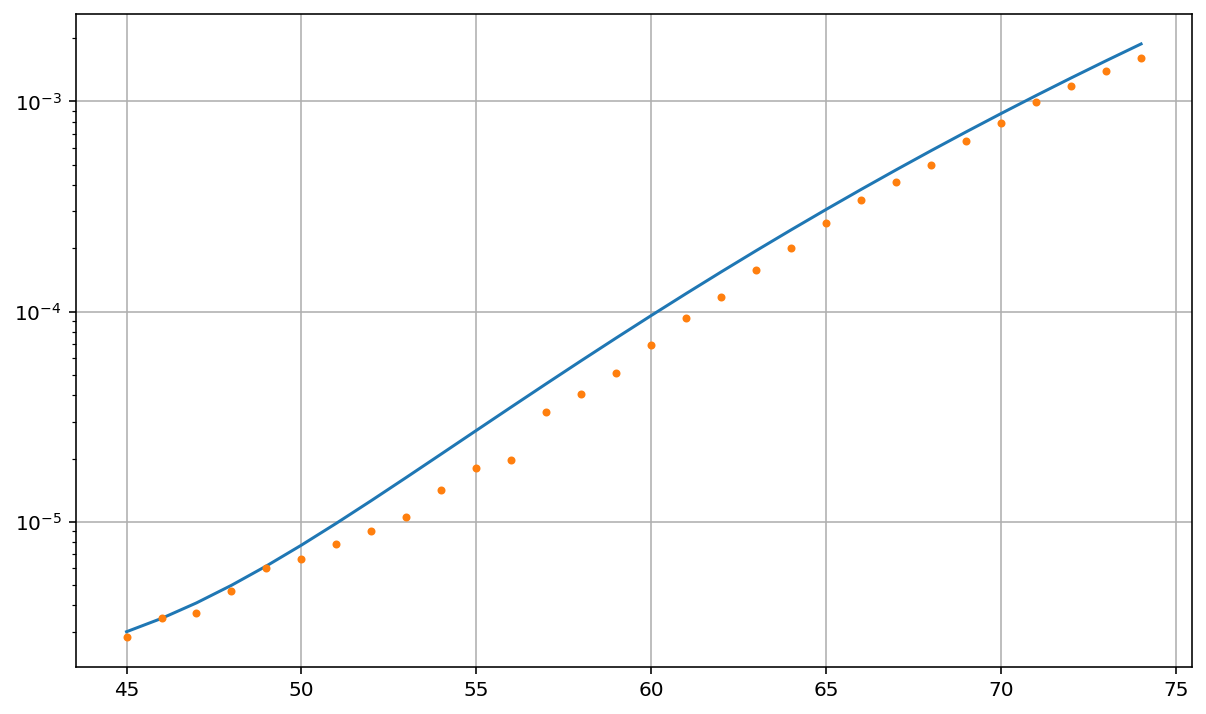

In [180]:
t0 = 45
tf = len(dataset[0,:])
mortality = 0.02
def sir(y, t, p):
    ds = -y[3] * y[0] * y[1]
    di = y[3] * y[0] * y[1] - y[4] * y[1]
    dr = y[4] * y[1]
    dbeta = -y[5] * y[3]
    dgamma = 0.
    dkb = 0 * (1-y[5])
    #dmult = 0#-1e-8 * y[6]
    return [ds, di, dr, dbeta, dgamma, dkb]

p = []
# US

N = 300e6
i0 = 3000. / N
r0 = 18 / mortality / N
confirmed_ratio = 8
beta = 0.36
gamma = 0.04
kb = 2e-2
t = np.arange(t0, tf)
y = odeint(sir, t=t, y0=[1.-i0-r0, i0, r0, beta, gamma, kb],
           args=(p,), rtol=1e-8, )

dataset_scaled = np.zeros_like(dataset, dtype=float)
dataset_scaled[0, :] = dataset[0, :] * confirmed_ratio / N
dataset_scaled[1, :] = dataset[1, :] / N / mortality

plt.figure()
plt.semilogy(t, y[:,1])
plt.semilogy(range(t0, dataset_scaled.shape[1]), dataset_scaled[0, range(t0, dataset.shape[1])], '.')

plt.figure()
plt.semilogy(t, y[:,2])
plt.semilogy(range(t0, dataset_scaled.shape[1]), dataset_scaled[1, range(t0, dataset.shape[1])], '.')

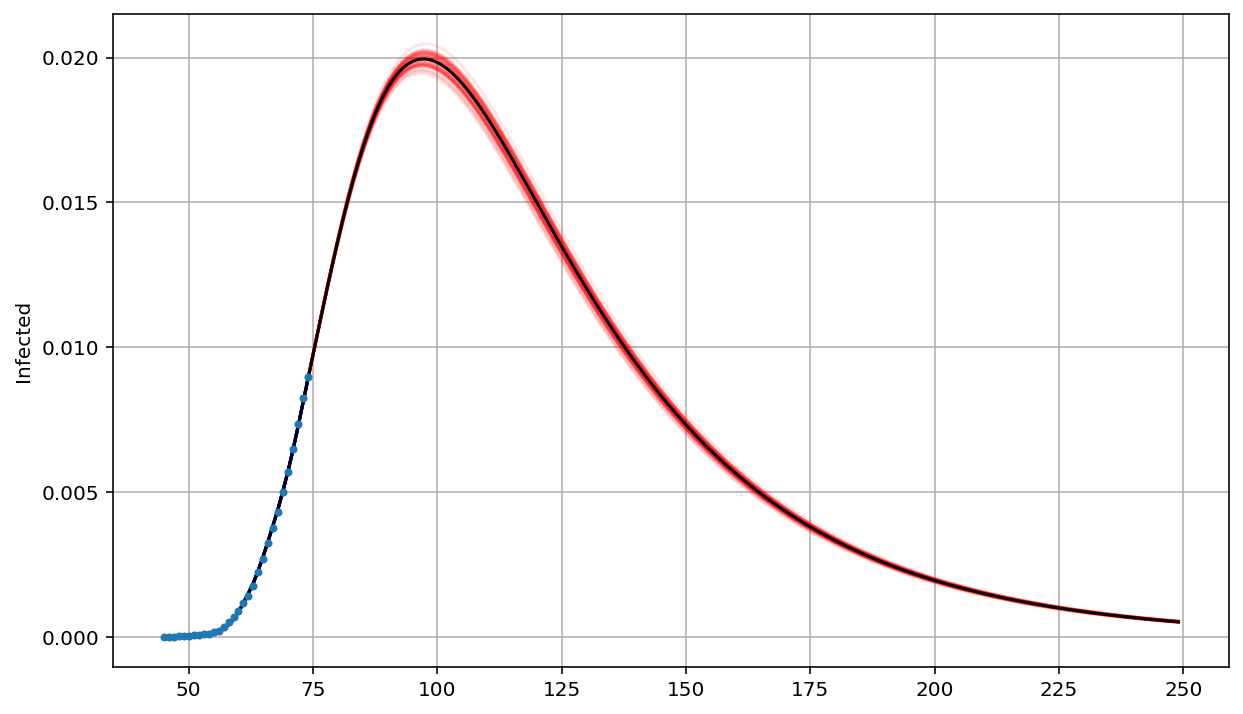

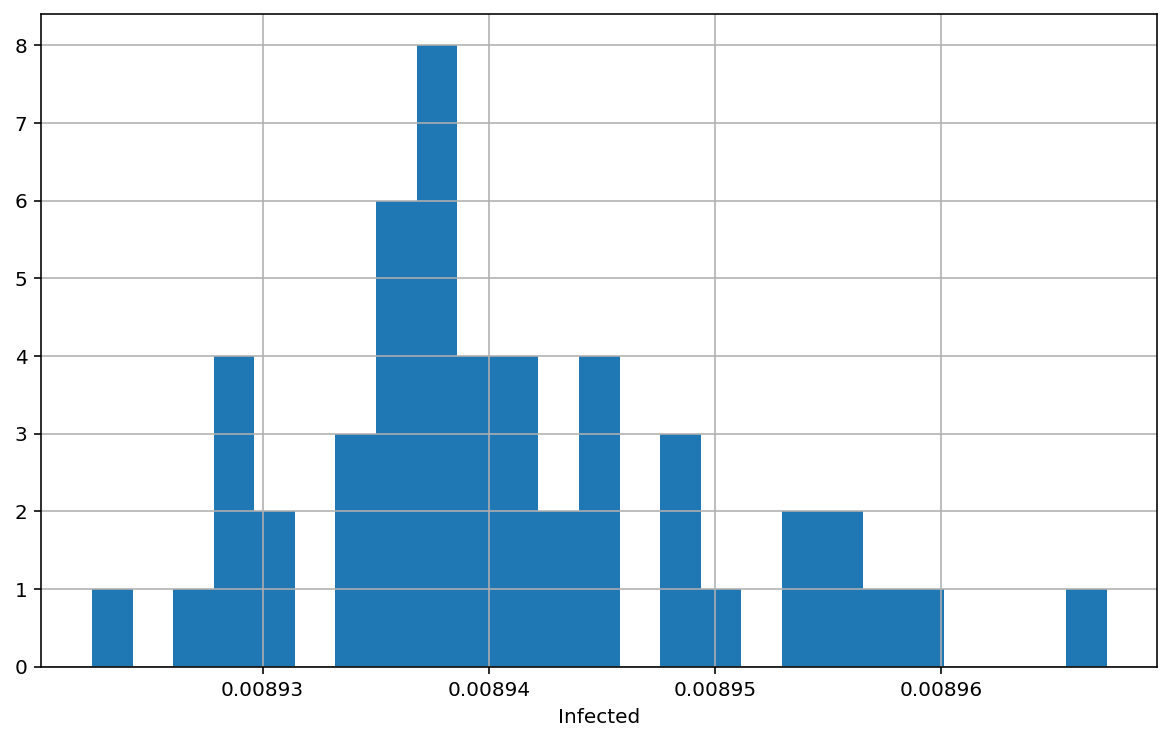

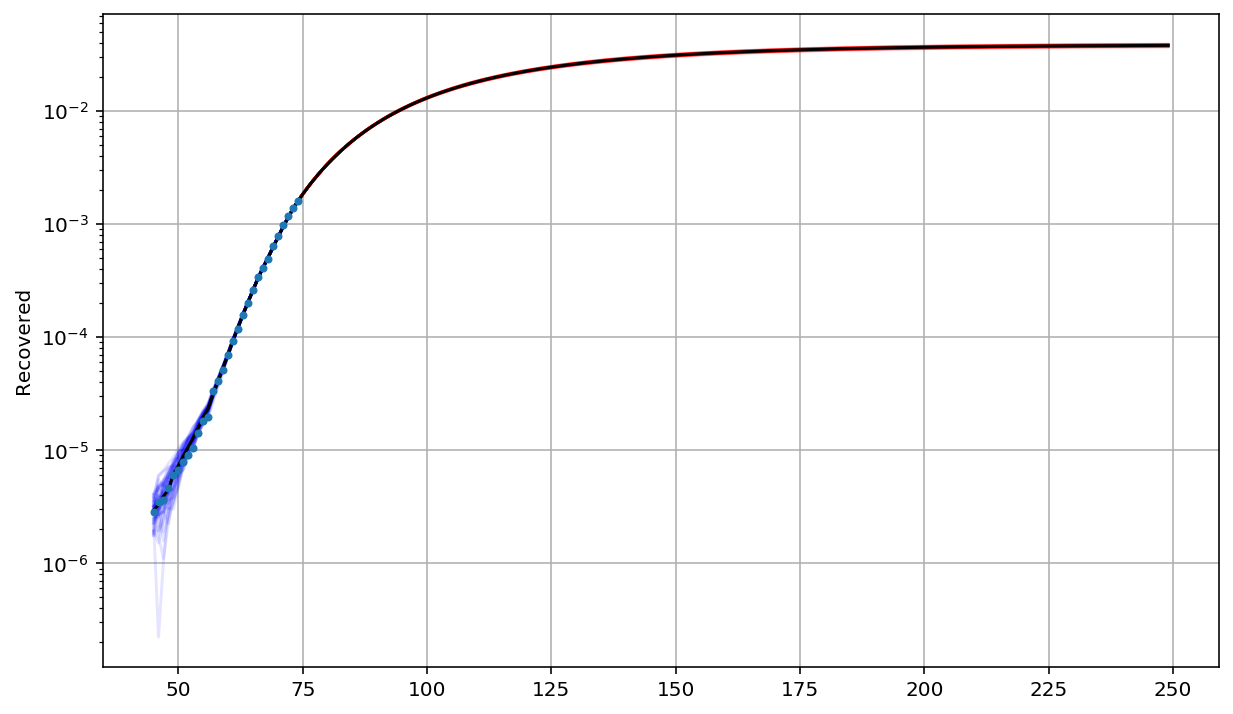

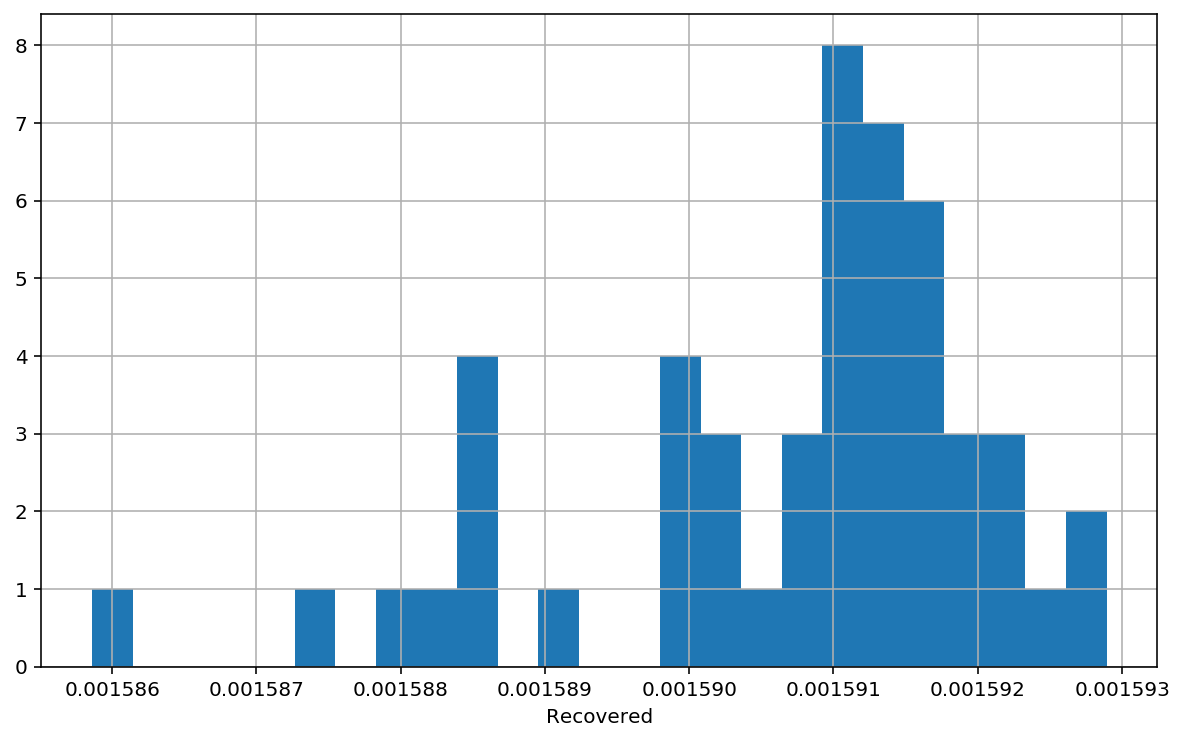

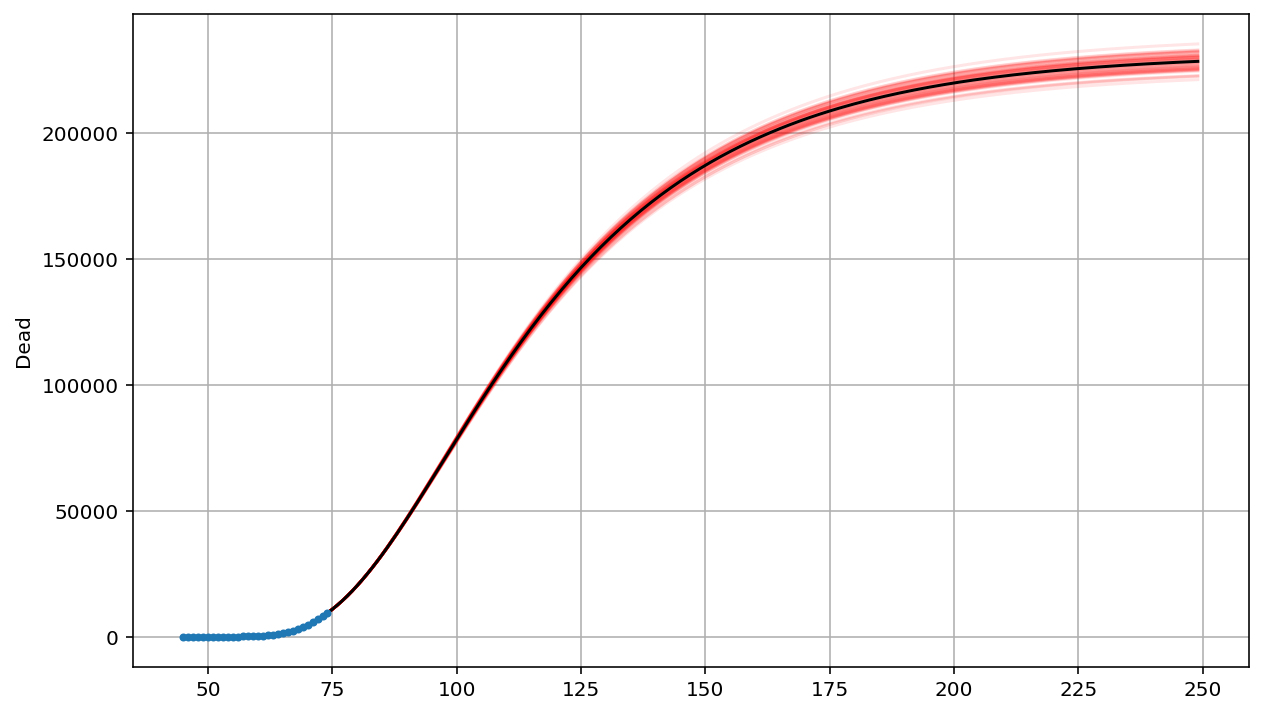

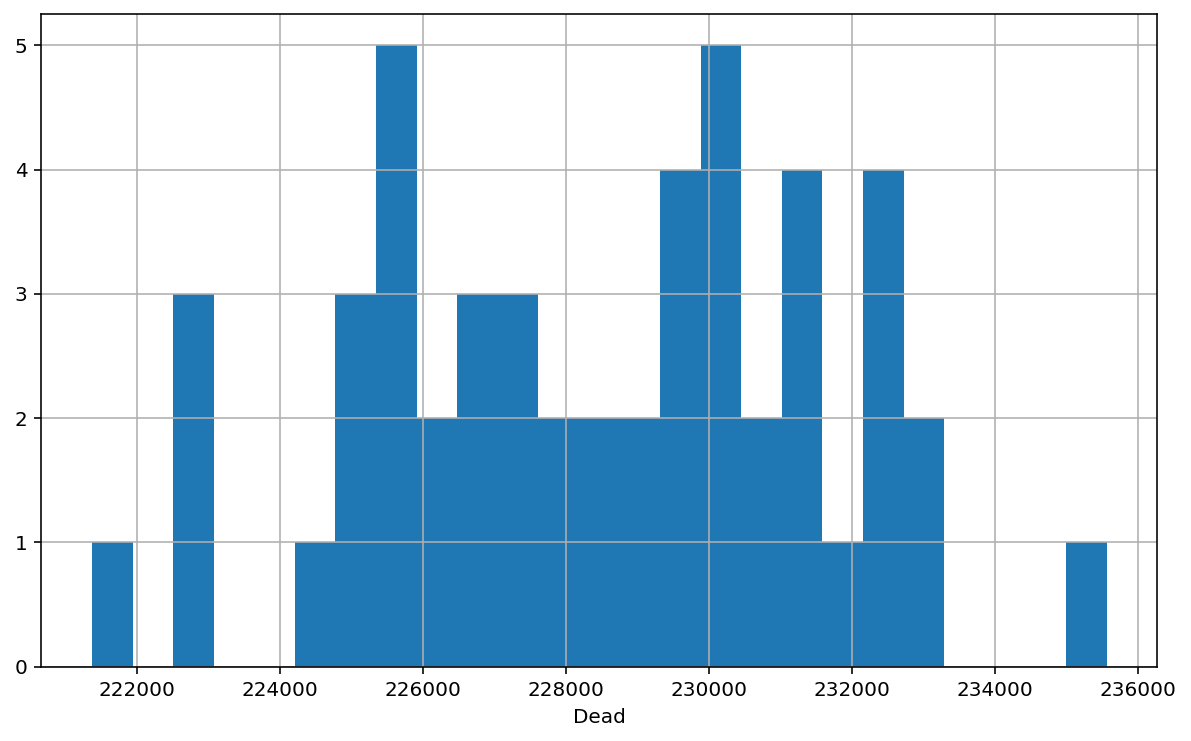

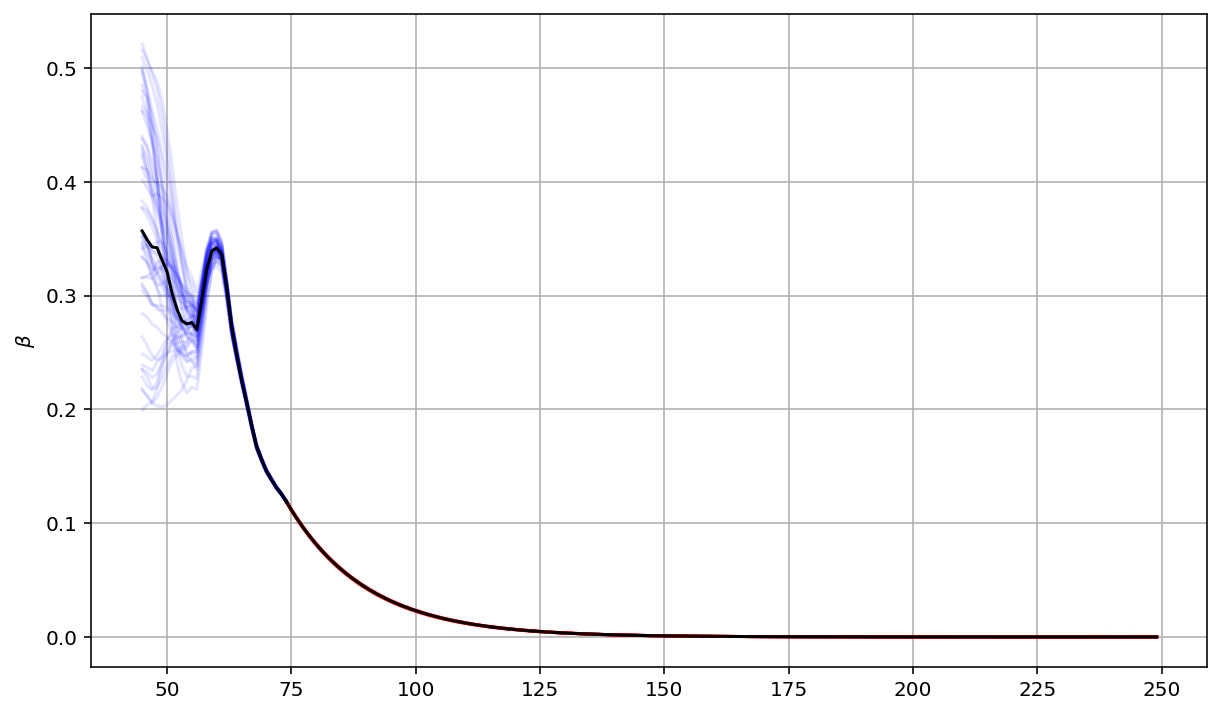

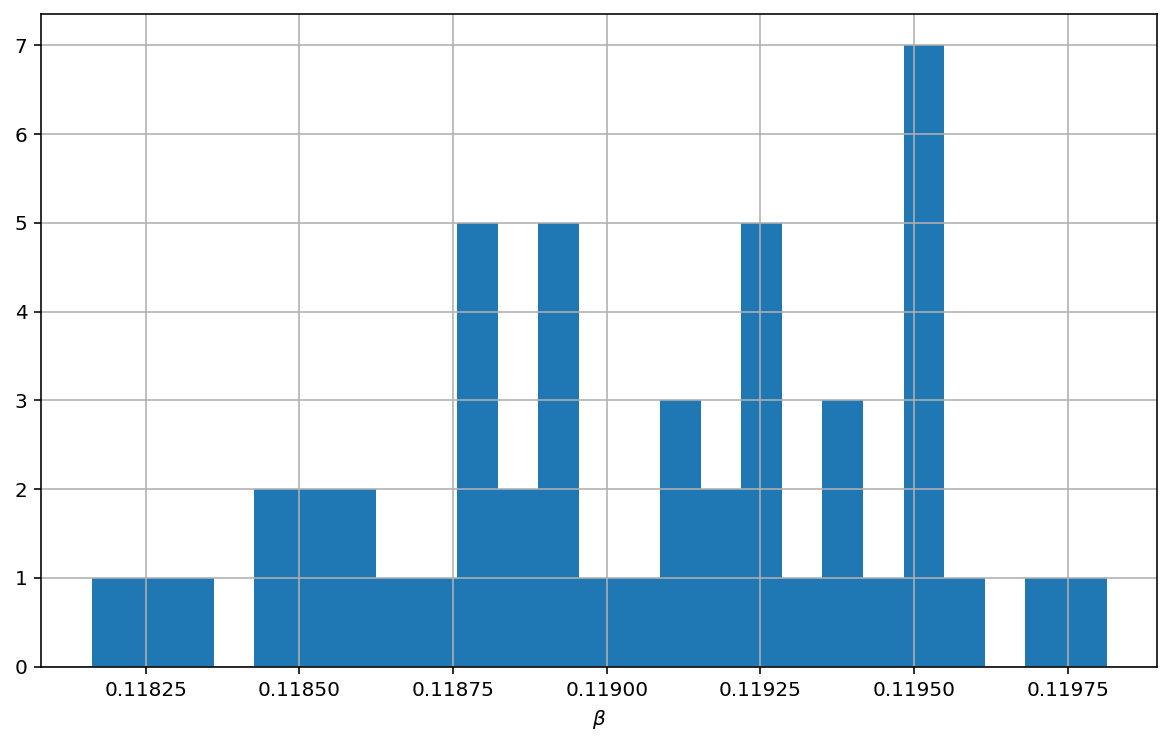

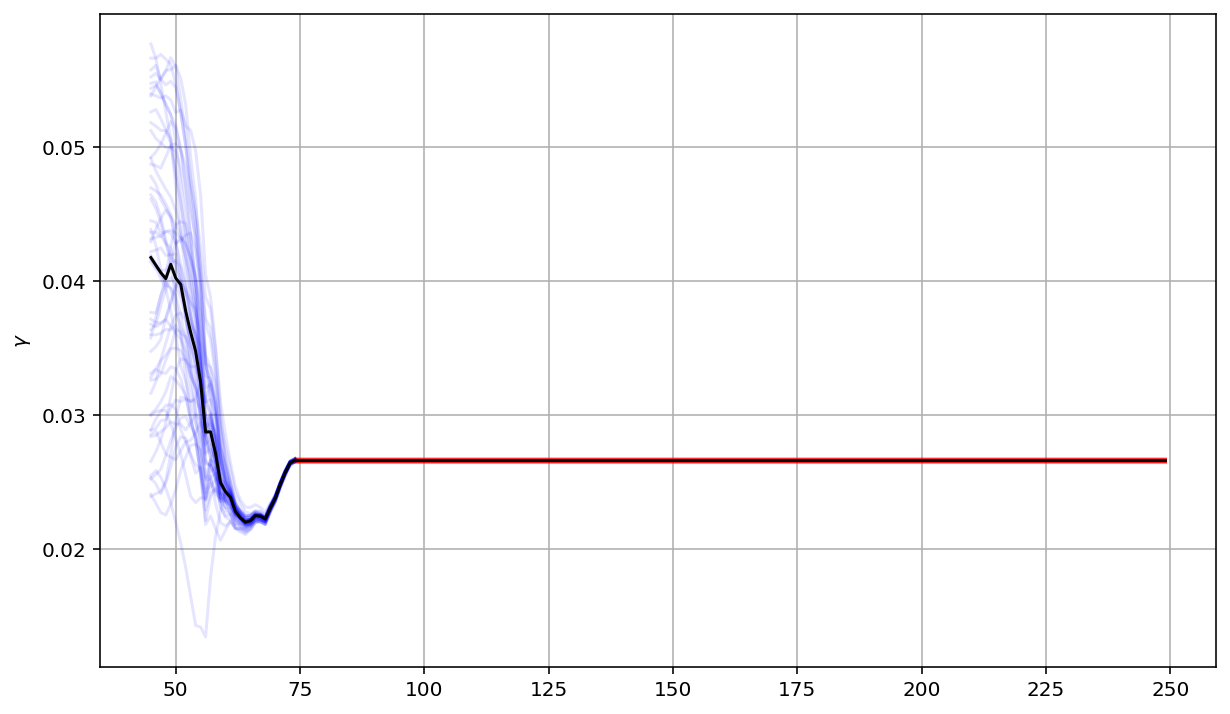

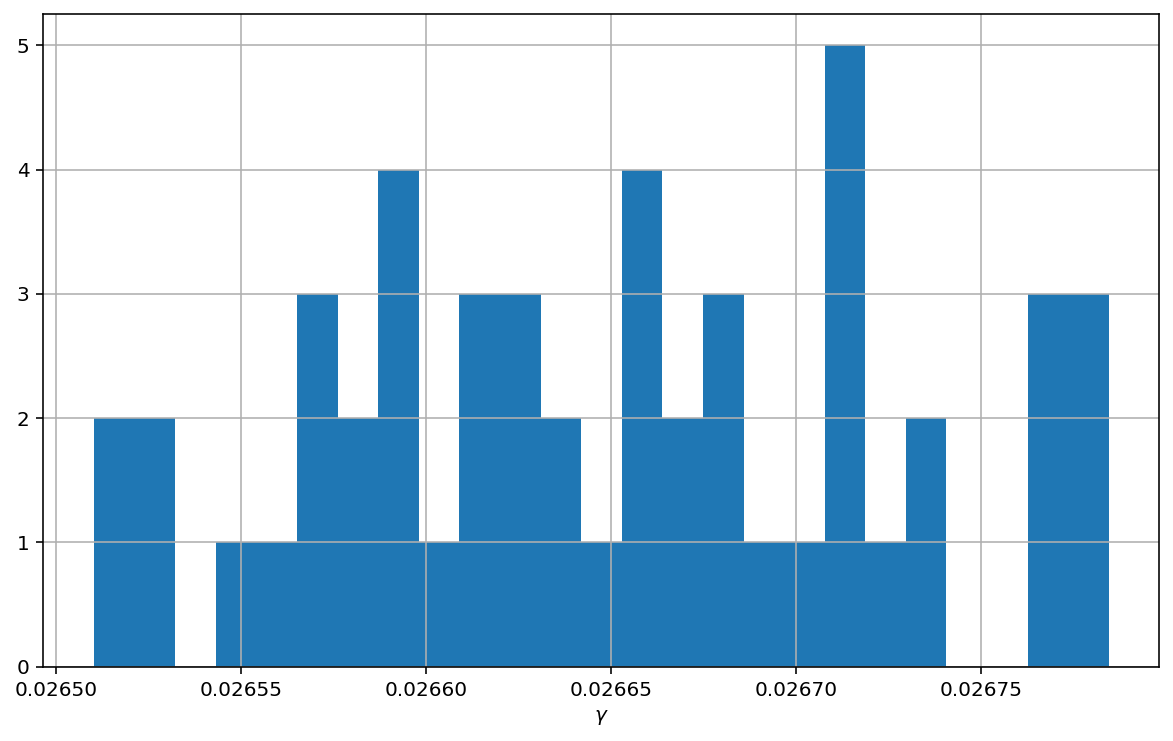

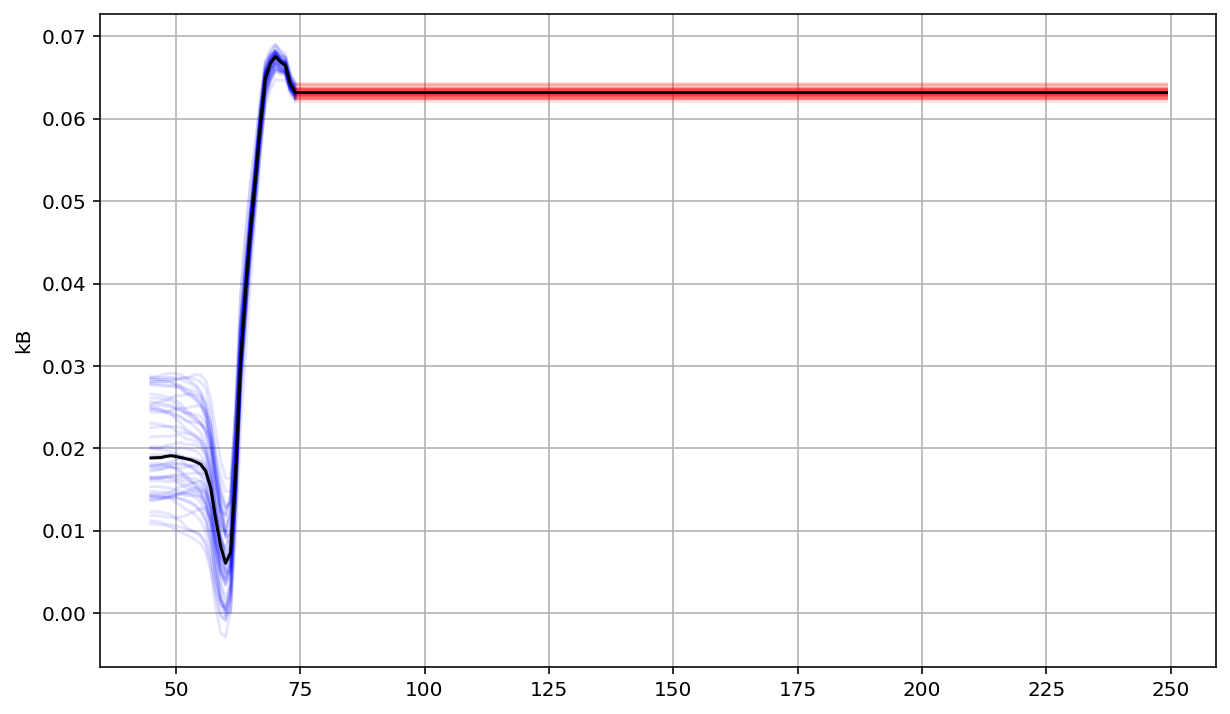

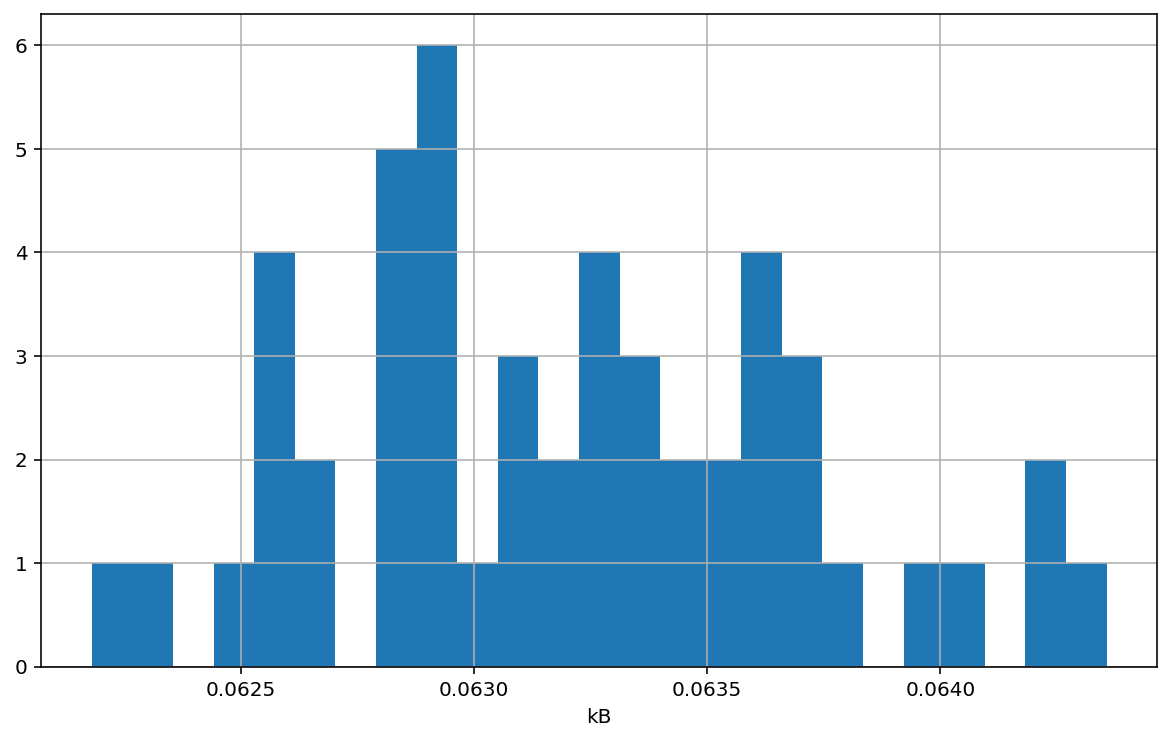

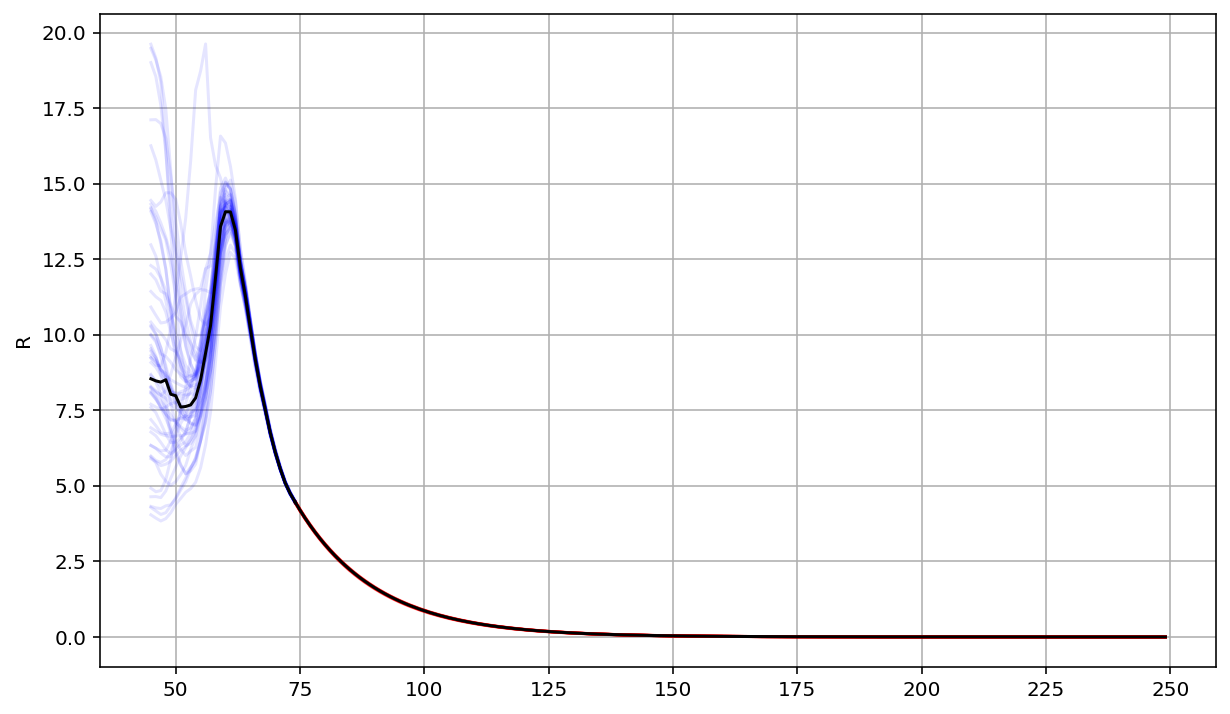

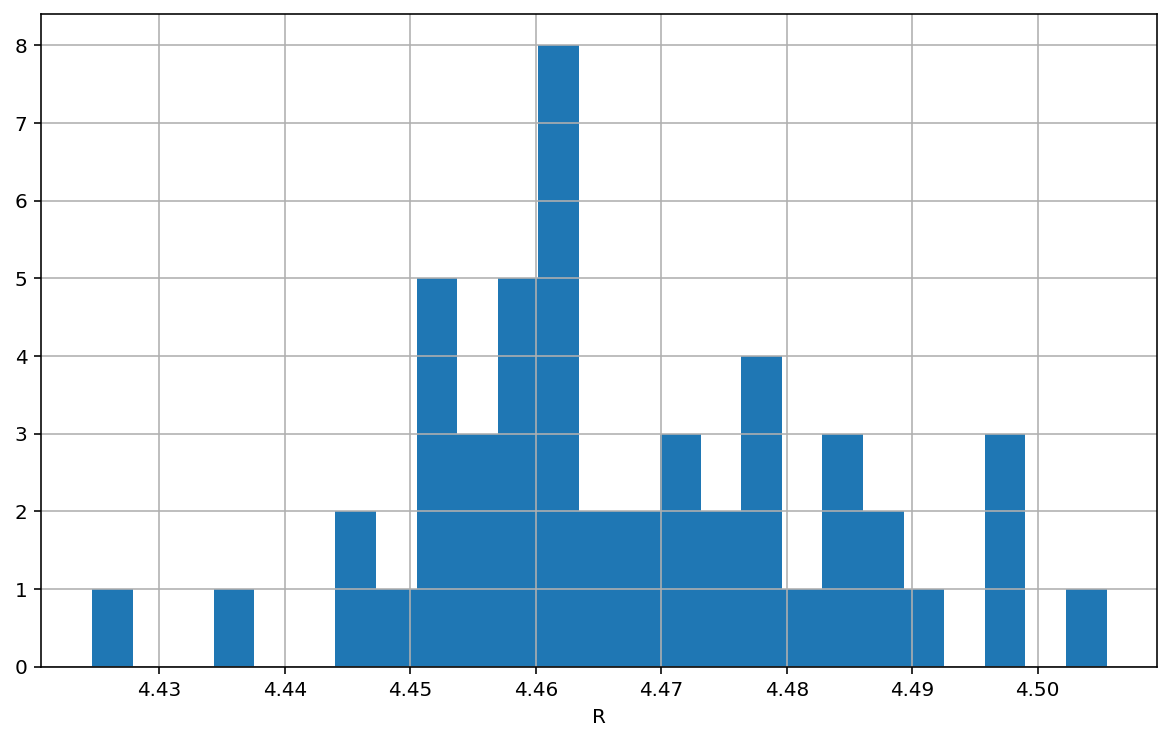

In [199]:
# Following https://arxiv.org/pdf/0901.3725.pdf

def KF_update(X_prior, H, D, R):
    N = X_prior.shape[1]
    X_post = np.zeros_like(X_prior)
    A = X_prior.T - np.mean(X_prior, axis=1)   # Should this be evaluated at t or t-1?
    C = A.T @ A / float(N-1)
    K = C @ H.T @ np.linalg.pinv(H @ C @ H.T + R)
    for j in range(N):
        X_post[:, j] = X_prior[:, j] + K @ (D[:,j] - H @ X_prior[:, j])
    return X_post

def EnKF(data, t0, tf, dt=1., N_ensb=50, tforecast=250,
         cov_model=[1e-6, 1e-6, 1e-6, 1e-5, 1e-5, 1e-5], cov_obs=[2e-5, 3e-6]): #cov_obs=[2e-4, 5e-5], cov_model=[5e-5, 5e-5]
    
    var0 = np.array([0.9, 0.9, 0.9, 0.9, 0.9])
    cov_model = np.array(cov_model)
    cov_obs = np.array(cov_obs)
    I0 = uniform((1.-var0[0]/2)*i0, var0[0]*i0).rvs(size=N_ensb)
    R0 = uniform((1.-var0[1]/2)*r0, var0[1]*r0).rvs(size=N_ensb)
    S0 = 1. - I0 - R0
    Beta0 = uniform((1.-var0[2]/2)*beta, var0[2]*beta).rvs(size=N_ensb)
    Gamma0 = uniform((1.-var0[3]/2)*gamma, var0[3]*gamma).rvs(size=N_ensb)
    Kb0 = uniform((1.-var0[4]/2)*kb, var0[4]*kb).rvs(size=N_ensb)
    
    tv = np.arange(t0, tf)
    Xs_prior = np.zeros((len(cov_model), N_ensb, len(tv)))
    Xs_prior[:, :, 0] = [
        S0, I0, R0, Beta0, Gamma0, Kb0
    ]
    Xs_post = Xs_prior.copy()
    H = np.array([[0, 1, 0, 0, 0, 0],
                  [0, 0, 1, 0, 0, 0]])
    
    R = np.array([[cov_obs[0]**2, 0],
                  [0, cov_obs[1]**2]])
    
    Q = multivariate_normal(mean=np.zeros([len(cov_model)]), cov=cov_model**2)
    
    D = np.array([norm(loc=data[0,t0], scale=cov_obs[0]*data[0,t0]).rvs(size=N_ensb) * confirmed_ratio, 
                  norm(loc=data[1,t0], scale=cov_obs[1]*data[1,t0]).rvs(size=N_ensb)])
    
    Xs_post[:, :, 0] = KF_update(Xs_prior[:, :, 0], H, D, R)
    
    for i in range(1, len(tv)):
        D = np.array([
            norm(loc=data[0,tv[i]], scale=cov_obs[0]*data[0,tv[i]]).rvs(size=N_ensb), 
            norm(loc=data[1,tv[i]], scale=cov_obs[1]*data[1,tv[i]]).rvs(size=N_ensb)]
        )
        
        #D = (np.ones([N_ensb, 2]) * data[:,i+t0]).T

        # Step
        for j in range(Xs_prior.shape[1]):
            Xs_prior[:, j, i] = odeint(sir, t=[tv[i-1], tv[i]], y0=Xs_post[:, j, i-1],
                                   args=(p,), rtol=1e-8)[-1] + Q.rvs()
            Xs_prior[0, j, i] = 1. - Xs_prior[1, j, i] - Xs_prior[2, j, i]
        
        # Update
        Xs_post[:, :, i] = KF_update(Xs_prior[:, :, i], H, D, R)
        
    
    # Forecast forward
    tvf = np.arange(tf-1, tforecast)
    X_forecast = np.zeros([len(cov_model), N_ensb, len(tvf)])
    for j in range(X_forecast.shape[1]):
        X_forecast[:, j, :] = odeint(sir, t=tvf, y0=Xs_post[:, j, -1],
                                   args=(p,), rtol=1e-8).T
    
    alpha = 0.1
    plt.figure()
    for j in range(Xs_prior.shape[1]):
        plt.plot(tvf, X_forecast[1, j, :], color='r', alpha=alpha)
        plt.plot(tv, Xs_post[1, j, :], color='b', alpha=alpha)
    plt.plot(tv, np.median(Xs_post[1, :, :], axis=0), color='k')
    plt.plot(tvf, np.median(X_forecast[1, :, :], axis=0), color='k')
    plt.plot(range(t0, tf), data[0, range(t0, tf)], '.')
    plt.ylabel('Infected')
    
    plt.figure()
    plt.hist(Xs_post[1, :, -1], bins=25)
    plt.xlabel('Infected')
    
    plt.figure()
    for j in range(Xs_prior.shape[1]):
        plt.semilogy(tvf, X_forecast[2, j, :], color='r', alpha=alpha)
        plt.semilogy(tv, Xs_post[2, j, :], color='b', alpha=alpha)
    plt.semilogy(tv, np.median(Xs_post[2, :, :], axis=0), color='k')
    plt.semilogy(tvf, np.median(X_forecast[2, :, :], axis=0), color='k')
    plt.semilogy(range(t0, tf), data[1, range(t0, tf)], '.')
    plt.ylabel('Recovered')
    
    plt.figure()
    plt.hist(Xs_post[2, :, -1], bins=25)
    plt.xlabel('Recovered')
    
    plt.figure()
    for j in range(Xs_prior.shape[1]):
        plt.plot(tvf, N*mortality*X_forecast[2, j, :], color='r', alpha=alpha)
        plt.plot(tv, N*mortality*Xs_post[2, j, :], color='b', alpha=alpha)
    plt.plot(tv, np.median(N*mortality*Xs_post[2, :, :], axis=0), color='k')
    plt.plot(tvf, np.median(N*mortality*X_forecast[2, :, :], axis=0), color='k')
    plt.plot(range(t0, tf), N*mortality*data[1, range(t0, tf)], '.')
    plt.ylabel('Dead')
    
    plt.figure()
    plt.hist(N*mortality*X_forecast[2, :, -1], bins=25)
    plt.xlabel('Dead')
    
    plt.figure()
    for j in range(Xs_prior.shape[1]):
        plt.plot(tvf, X_forecast[3, j, :], color='r', alpha=alpha)
        plt.plot(tv, Xs_post[3, j, :], color='b', alpha=alpha)
    plt.plot(tv, np.median(Xs_post[3, :, :], axis=0), color='k')
    plt.plot(tvf, np.median(X_forecast[3, :, :], axis=0), color='k')
    plt.ylabel(r'$\beta$')
    
    plt.figure()
    plt.hist(Xs_post[3, :, -1], bins=25)
    plt.xlabel(r'$\beta$')
        
    plt.figure()
    for j in range(Xs_prior.shape[1]):
        plt.plot(tvf, X_forecast[4, j, :], color='r', alpha=alpha)
        plt.plot(tv, Xs_post[4, j, :], color='b', alpha=alpha)
    plt.plot(tv, np.median(Xs_post[4, :, :], axis=0), color='k')
    plt.plot(tvf, np.median(X_forecast[4, :, :], axis=0), color='k')
    plt.ylabel(r'$\gamma$')
    
    plt.figure()
    plt.hist(Xs_post[4, :, -1], bins=25)
    plt.xlabel(r'$\gamma$')
    
    plt.figure()
    for j in range(Xs_prior.shape[1]):
        plt.plot(tvf, X_forecast[5, j, :], color='r', alpha=alpha)
        plt.plot(tv, Xs_post[5, j, :], color='b', alpha=alpha)
    plt.plot(tv, np.median(Xs_post[5, :, :], axis=0), color='k')
    plt.plot(tvf, np.median(X_forecast[5, :, :], axis=0), color='k')
    plt.ylabel('kB')
    
    plt.figure()
    plt.hist(Xs_post[5, :, -1], bins=25)
    plt.xlabel(r'kB')
    
    plt.figure()
    for j in range(Xs_prior.shape[1]):
        plt.plot(tvf, X_forecast[3, j, :]/X_forecast[4, j, :], color='r', alpha=alpha)
        plt.plot(tv, Xs_post[3, j, :] / Xs_post[4, j, :], color='b', alpha=alpha)
    plt.plot(tv, np.median(Xs_post[3, :, :], axis=0) / np.median(Xs_post[4, :, :], axis=0), color='k')
    plt.plot(tvf, np.median(X_forecast[3, :, :], axis=0) / np.median(X_forecast[4, :, :], axis=0), color='k')
    plt.ylabel('R')
    
    plt.figure()
    plt.hist(Xs_post[3, :, -1] / Xs_post[4, :, -1], bins=25)
    plt.xlabel(r'R')

EnKF(dataset_scaled, t0, tf)